In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

OK, first, let's load up the light curve.

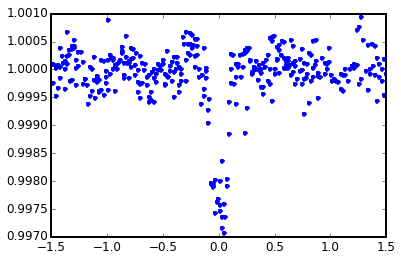

In [2]:
t, f, f_err = np.loadtxt('k2_test.csv', delimiter=',', unpack=True)
m = np.absolute(t) < 1.5
t=t[m]; f=f[m]; f_err=f_err[m]
plt.plot(t, f, '.');

Hmm, some odd-looking residuals here.  But let's move on.  In order to run the following, you have to have my [`transitfit`](http://github.com/timothydmorton/transit-fitting) package installed, as well as my branch of DFM's [`transit`](http://github.com/timothydmorton/transit) package.

In [46]:
from transitfit import LightCurve, Planet, TransitModel

planet = Planet((14.5665,0.002), (0.0, 0.002), 4.73/24)
lc = LightCurve(t, f, f_err, texp=1626./86400, planets=[planet],
               detrend=False, rhostar=(3.92,1.43), 
               dilution=(0.01, 0.001)) #rhostar, dilution from paper
mod = TransitModel(lc)

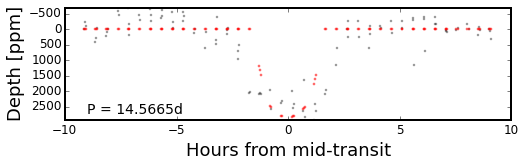

In [47]:
pars = lc.default_params
mod.plot_planets(pars);

In [48]:
sampler = mod.fit_emcee()

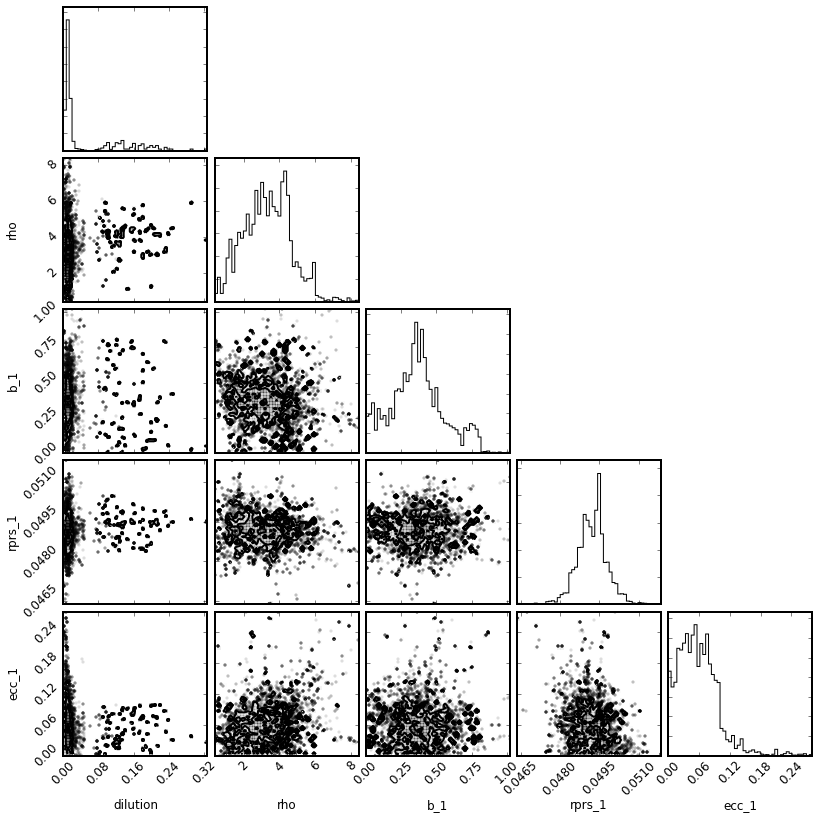

In [49]:
mod.triangle(['dilution', 'rho', 'b_1', 'rprs_1', 'ecc_1']);

In [55]:
mod.samples.columns

Index([u'dilution', u'flux_zp', u'q1', u'q2', u'rho', u'period_1', u'epoch_1',
       u'b_1', u'rprs_1', u'ecc_1', u'omega_1'],
      dtype='object')

(-0.5, 0.5)

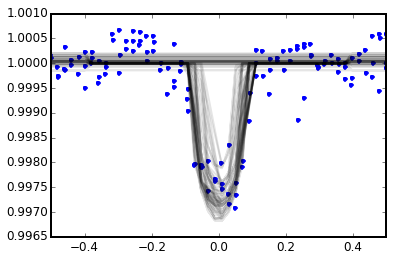

In [66]:
plt.plot(t, f, '.');
nsamples = 30
inds = np.random.randint(len(mod.samples), size=nsamples)
for _, s in mod.samples.iloc[inds].iterrows():
    p = (s.flux_zp, s.rho, s.q1, s.q2, s.dilution, 
         s.period_1, s.epoch_1, s.b_1, s.rprs_1, s.ecc_1, s.omega_1)
    plt.plot(t, mod.evaluate(p), 'k', alpha=0.1)
plt.xlim(-0.5, 0.5)

Let's try another version with $\rho_\star$ from my stellar model:

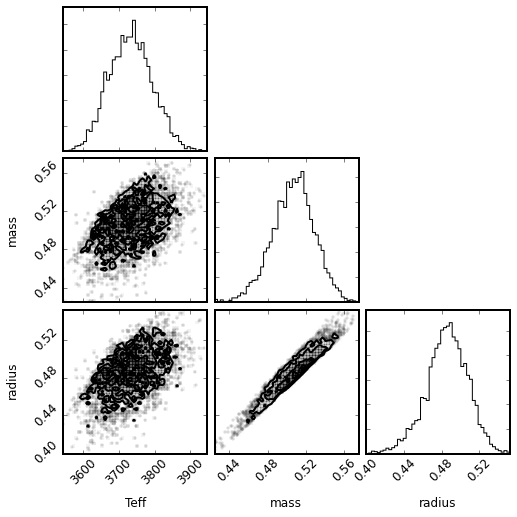

In [38]:
from isochrones import StarModel
mod = StarModel.load_hdf('k2_starmodel.h5')
mod.triangle(['Teff','mass','radius']);

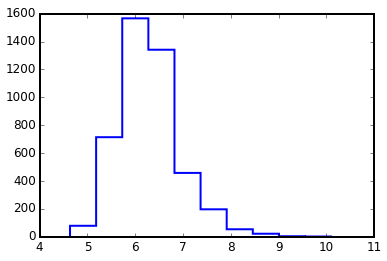

In [40]:
from astropy import constants as const
RSUN = const.R_sun.cgs.value
MSUN = const.M_sun.cgs.value

rhostar = mod.samples.mass * MSUN / (4./3 * np.pi * 
                                     (mod.samples.radius * RSUN) **3)
plt.hist(rhostar, histtype='step', lw=2);

And, do the model fit again, this time using these samples:

In [44]:
planet = Planet((14.5665,0.002), (0.0, 0.002), 4.73/24)
lc2 = LightCurve(t, f, f_err, texp=1626./86400, planets=[planet],
               detrend=False, rhostar=rhostar, 
               dilution=(0.01, 0.001)) #dilution from paper; my rhostar
mod2 = TransitModel(lc2)

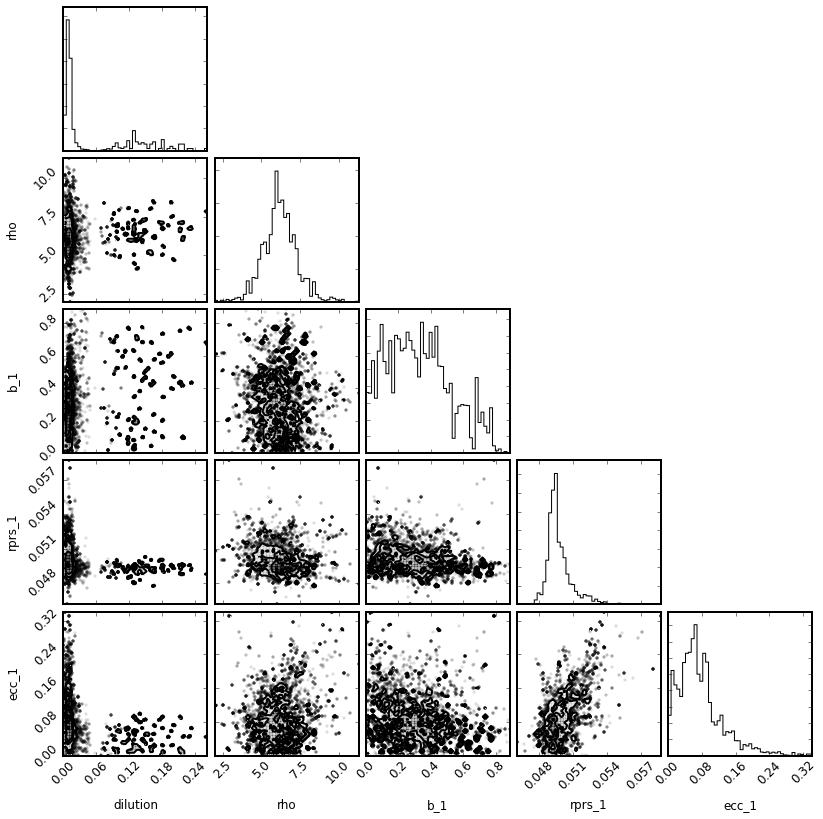

In [45]:
mod2.fit_emcee()
mod2.triangle(['dilution', 'rho', 'b_1', 'rprs_1', 'ecc_1']);

Doesn't seem to be much difference here, even with a higher stellar density prior.